In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Jan 19 12:38:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bmin_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.z_activation = F.tanh
hp.activation = F.sigmoid

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.19-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

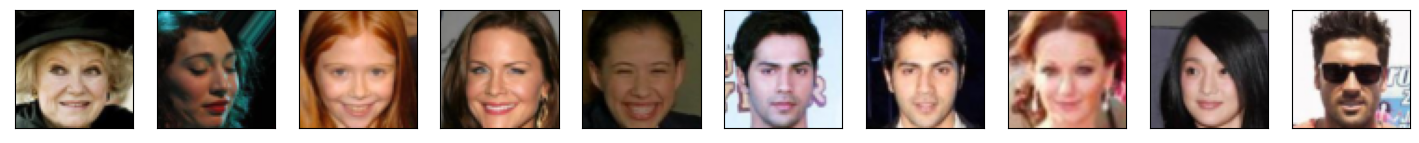

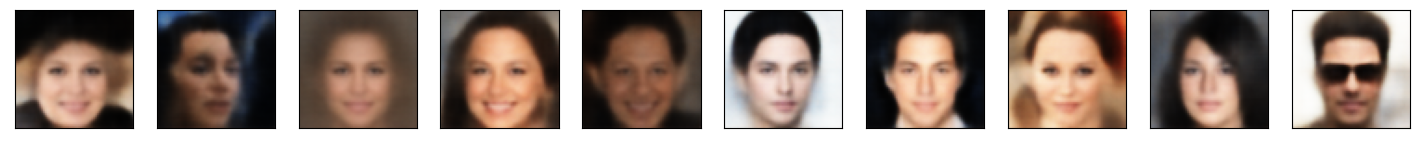

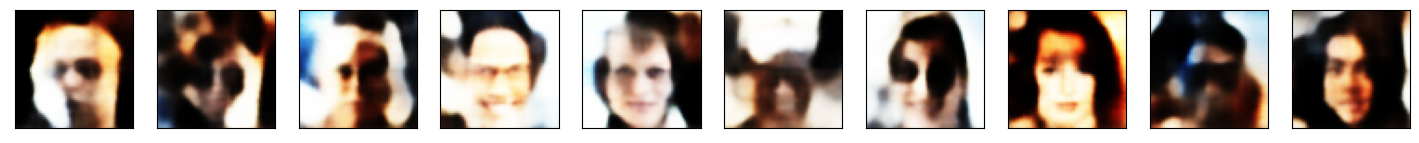

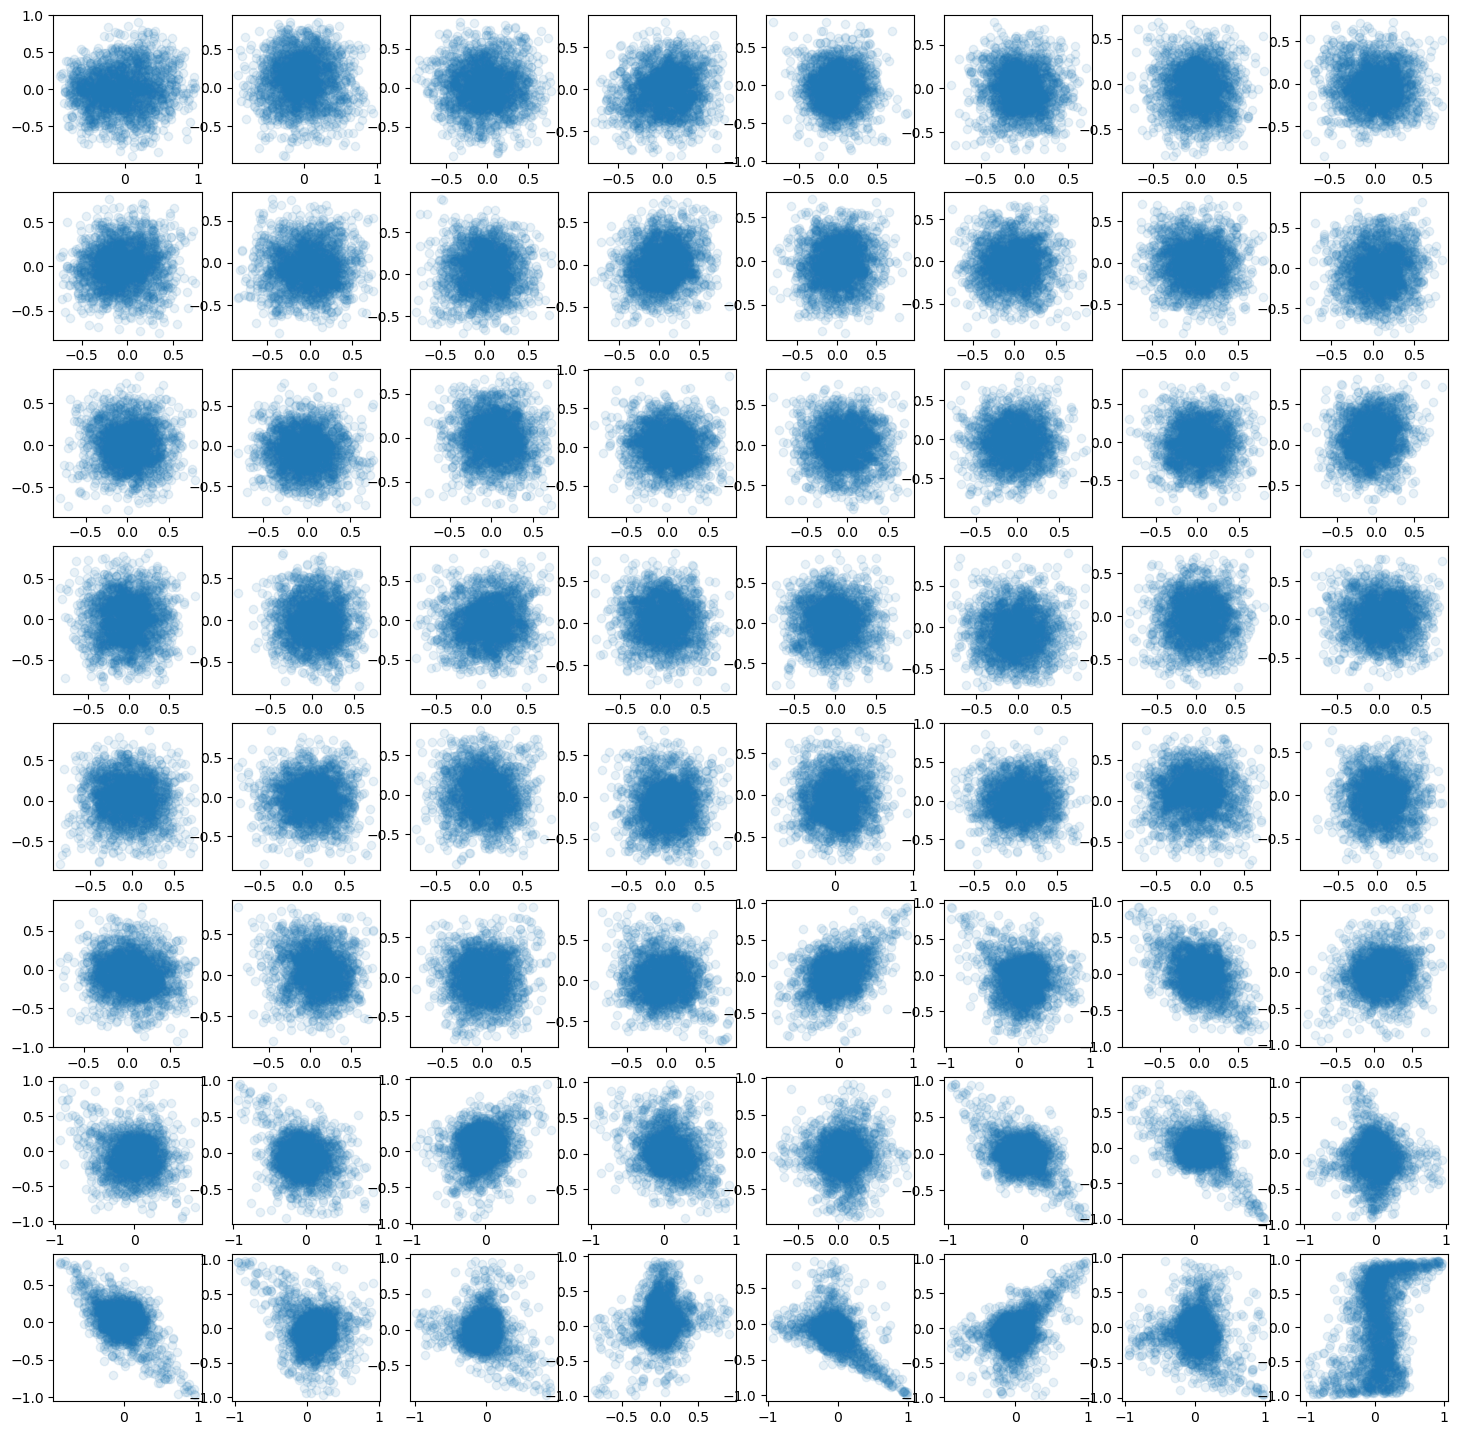

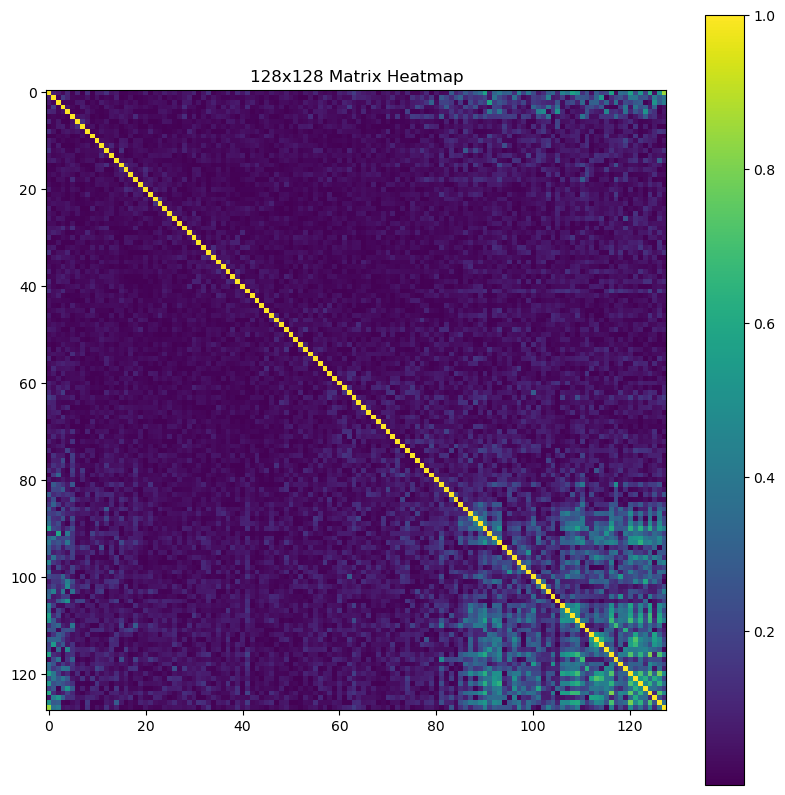

4001
lse_loss 0.007529905531555414
recon_loss 0.010091889649629593
4002
lse_loss 0.00913198571652174
recon_loss 0.010033301077783108
4003
lse_loss 0.008532396517693996
recon_loss 0.01138739101588726
4004
lse_loss 0.01005447655916214
recon_loss 0.010881978087127209
4005
lse_loss 0.007530296687036753
recon_loss 0.00981680117547512
4006
lse_loss 0.009142063558101654
recon_loss 0.010618258267641068
4007
lse_loss 0.007465241942554712
recon_loss 0.010407770983874798
4008
lse_loss 0.008005673065781593
recon_loss 0.008878457359969616
4009
lse_loss 0.007671271450817585
recon_loss 0.01030427310615778
4010
lse_loss 0.007289693225175142
recon_loss 0.009442294016480446
4011
lse_loss 0.008656151592731476
recon_loss 0.010837983340024948
4012
lse_loss 0.0082772858440876
recon_loss 0.011230600997805595
4013
lse_loss 0.008808042854070663
recon_loss 0.008754488080739975
4014
lse_loss 0.008419431746006012
recon_loss 0.010022766888141632
4015
lse_loss 0.00916119385510683
recon_loss 0.01001865603029728
4016

4125
lse_loss 0.009494367986917496
recon_loss 0.0116643738001585
4126
lse_loss 0.0076394472271203995
recon_loss 0.009049122221767902
4127
lse_loss 0.009462796151638031
recon_loss 0.00881459191441536
4128
lse_loss 0.00978710874915123
recon_loss 0.010617929510772228
4129
lse_loss 0.006998633034527302
recon_loss 0.011258026584982872
4130
lse_loss 0.007684912066906691
recon_loss 0.009515892714262009
4131
lse_loss 0.009341521188616753
recon_loss 0.010484904050827026
4132
lse_loss 0.010159710422158241
recon_loss 0.00929318368434906
4133
lse_loss 0.009907076135277748
recon_loss 0.008702309802174568
4134
lse_loss 0.007998216897249222
recon_loss 0.010393056087195873
4135
lse_loss 0.009507181122899055
recon_loss 0.009348946623504162
4136
lse_loss 0.0085708387196064
recon_loss 0.01055220142006874
4137
lse_loss 0.00768527016043663
recon_loss 0.009945753961801529
4138
lse_loss 0.009593021124601364
recon_loss 0.00964020099490881
4139
lse_loss 0.007523319683969021
recon_loss 0.009711455553770065
4140

4249
lse_loss 0.007795549463480711
recon_loss 0.009558064863085747
4250
lse_loss 0.008763659745454788
recon_loss 0.01033090241253376
4251
lse_loss 0.008469483815133572
recon_loss 0.011049452237784863
4252
lse_loss 0.009905975311994553
recon_loss 0.010415244847536087
4253
lse_loss 0.008318963460624218
recon_loss 0.0100889652967453
4254
lse_loss 0.007975074462592602
recon_loss 0.010113532654941082
4255
lse_loss 0.009930813685059547
recon_loss 0.010478991083800793
4256
lse_loss 0.009470599703490734
recon_loss 0.009490923956036568
4257
lse_loss 0.008291483856737614
recon_loss 0.009592723101377487
4258
lse_loss 0.008047536015510559
recon_loss 0.010282058268785477
4259
lse_loss 0.009785006754100323
recon_loss 0.010349778458476067
4260
lse_loss 0.010259137488901615
recon_loss 0.009620744735002518
4261
lse_loss 0.009240232408046722
recon_loss 0.00980277918279171
4262
lse_loss 0.008016277104616165
recon_loss 0.011057456955313683
4263
lse_loss 0.008778039366006851
recon_loss 0.010623810812830925

4373
lse_loss 0.009703371673822403
recon_loss 0.009429661557078362
4374
lse_loss 0.008666078560054302
recon_loss 0.00980700459331274
4375
lse_loss 0.010090338066220284
recon_loss 0.010159707628190517
4376
lse_loss 0.009602058678865433
recon_loss 0.010119399055838585
4377
lse_loss 0.007868191227316856
recon_loss 0.01031574048101902
4378
lse_loss 0.010929131880402565
recon_loss 0.009839221835136414
4379
lse_loss 0.01086510345339775
recon_loss 0.009420966729521751
4380
lse_loss 0.00898476131260395
recon_loss 0.010348552837967873
4381
lse_loss 0.007125841919332743
recon_loss 0.010062816552817822
4382
lse_loss 0.008077792823314667
recon_loss 0.011332424357533455
4383
lse_loss 0.010274460539221764
recon_loss 0.009834200143814087
4384
lse_loss 0.008091630414128304
recon_loss 0.009672381915152073
4385
lse_loss 0.009790511801838875
recon_loss 0.009893297217786312
4386
lse_loss 0.009195845574140549
recon_loss 0.009865280240774155
4387
lse_loss 0.007944229058921337
recon_loss 0.010007696226239204

4496
lse_loss 0.007285475730895996
recon_loss 0.010307245887815952
4497
lse_loss 0.009495178237557411
recon_loss 0.0095521230250597
4498
lse_loss 0.00954961683601141
recon_loss 0.009963607415556908
4499
lse_loss 0.007907630875706673
recon_loss 0.010057327337563038
4500
lse_loss 0.010646495968103409
recon_loss 0.009199703112244606
4501
lse_loss 0.008758582174777985
recon_loss 0.009943428449332714
4502
lse_loss 0.008536691777408123
recon_loss 0.009825515560805798
4503
lse_loss 0.009777616709470749
recon_loss 0.009910281747579575
4504
lse_loss 0.007509556598961353
recon_loss 0.009679754264652729
4505
lse_loss 0.00940978154540062
recon_loss 0.009884338825941086
4506
lse_loss 0.008864201605319977
recon_loss 0.00986207090318203
4507
lse_loss 0.008615809492766857
recon_loss 0.009838744066655636
4508
lse_loss 0.007831080816686153
recon_loss 0.009900592267513275
4509
lse_loss 0.00844641961157322
recon_loss 0.009706423617899418
4510
lse_loss 0.009690634906291962
recon_loss 0.010263561271131039
4

4620
lse_loss 0.008968455716967583
recon_loss 0.009258379228413105
4621
lse_loss 0.008708789013326168
recon_loss 0.0099611422047019
4622
lse_loss 0.010503098368644714
recon_loss 0.011050245724618435
4623
lse_loss 0.009289086796343327
recon_loss 0.010591741651296616
4624
lse_loss 0.01078646071255207
recon_loss 0.009186762385070324
4625
lse_loss 0.009674925357103348
recon_loss 0.009482117369771004
4626
lse_loss 0.009076444432139397
recon_loss 0.009636057540774345
4627
lse_loss 0.009866681881248951
recon_loss 0.01079594623297453
4628
lse_loss 0.009349077939987183
recon_loss 0.008548974059522152
4629
lse_loss 0.00950423814356327
recon_loss 0.010128464549779892
4630
lse_loss 0.008745352737605572
recon_loss 0.009767941199243069
4631
lse_loss 0.008335215970873833
recon_loss 0.010251235216856003
4632
lse_loss 0.008241213858127594
recon_loss 0.010616494342684746
4633
lse_loss 0.008959936909377575
recon_loss 0.010474510490894318
4634
lse_loss 0.008850173093378544
recon_loss 0.009737725369632244


4743
lse_loss 0.01044824905693531
recon_loss 0.009888659231364727
4744
lse_loss 0.006769474130123854
recon_loss 0.009689896367490292
4745
lse_loss 0.00821452122181654
recon_loss 0.009904884733259678
4746
lse_loss 0.010421283543109894
recon_loss 0.011465184390544891
4747
lse_loss 0.007715921849012375
recon_loss 0.009480091743171215
4748
lse_loss 0.00861741229891777
recon_loss 0.010349581949412823
4749
lse_loss 0.009184593334794044
recon_loss 0.00952586904168129
4750
lse_loss 0.007556488737463951
recon_loss 0.009836742654442787
4751
lse_loss 0.008708307519555092
recon_loss 0.00927512627094984
4752
lse_loss 0.00974990427494049
recon_loss 0.010844947770237923
4753
lse_loss 0.010911230929195881
recon_loss 0.009647254832088947
4754
lse_loss 0.008804628625512123
recon_loss 0.01001820620149374
4755
lse_loss 0.010493963956832886
recon_loss 0.010080616921186447
4756
lse_loss 0.00851230975240469
recon_loss 0.010507898405194283
4757
lse_loss 0.012019140645861626
recon_loss 0.009849952533841133
475

In [ ]:
from IPython import display

test_batch = next(iter(test_loader))
test_data = preprocess(test_batch)
            
while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 3e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                test_data = model(test_data, M=hp.M)
            
            plot(test_data['x'])
            plot(test_data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
            
            z = test_data['z_copy'].data.cpu().numpy()
            plt.figure(figsize=[18, 18])
            for i in range(64):
                plt.subplot(8, 8, i+1)
                plt.scatter(z[:, i*2], z[:, i*2+1], alpha=0.1)
            plt.show()    
                
            corrcoef = torch.corrcoef(test_data['z_copy'].T).abs().data.cpu().numpy()
            # Plotting the matrix as a heatmap
            plt.figure(figsize=(10, 10))
            plt.imshow(corrcoef, cmap='viridis')
            plt.colorbar()
            plt.title('128x128 Matrix Heatmap')
            plt.show()
            
            corrcoef = np.mean(corrcoef * (1-np.eye(len(corrcoef))))
            writer.add_scalar('corrcoef', corrcoef, step)
            
            from util.mmd_penalty import mmd_penalty
            opts = {'pz_scale': 1,
                    'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
                    'pz': 'normal', # 'normal', 'sphere', 'uniform' 
                    'zdim': hp.z_dim
                   } 
            e = (torch.rand_like(test_data['z_copy'])*2-1)
            mmd = mmd_penalty(test_data['z_copy'], e, opts).item()
            writer.add_scalar('MMD', mmd, step)
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [13]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


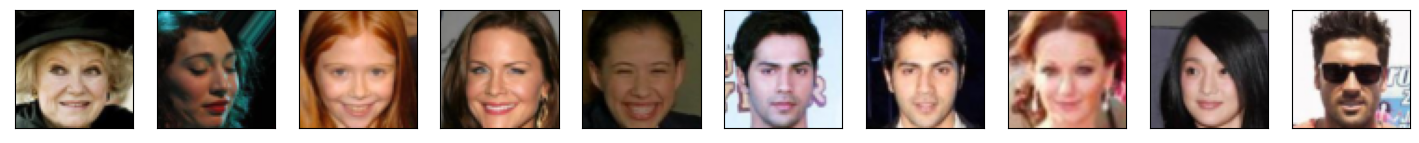

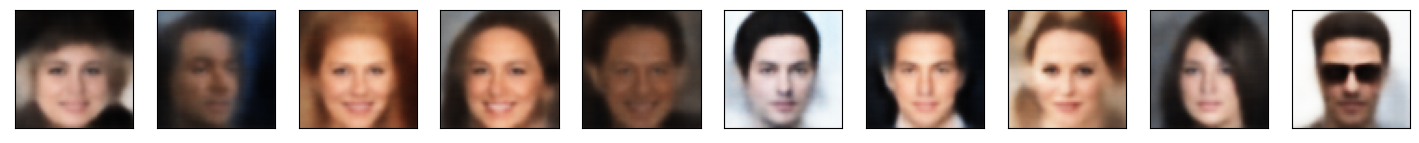

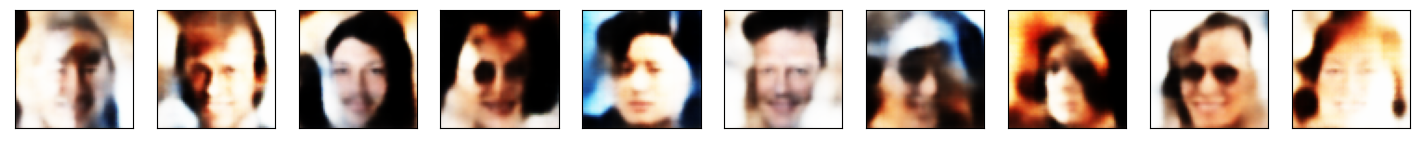

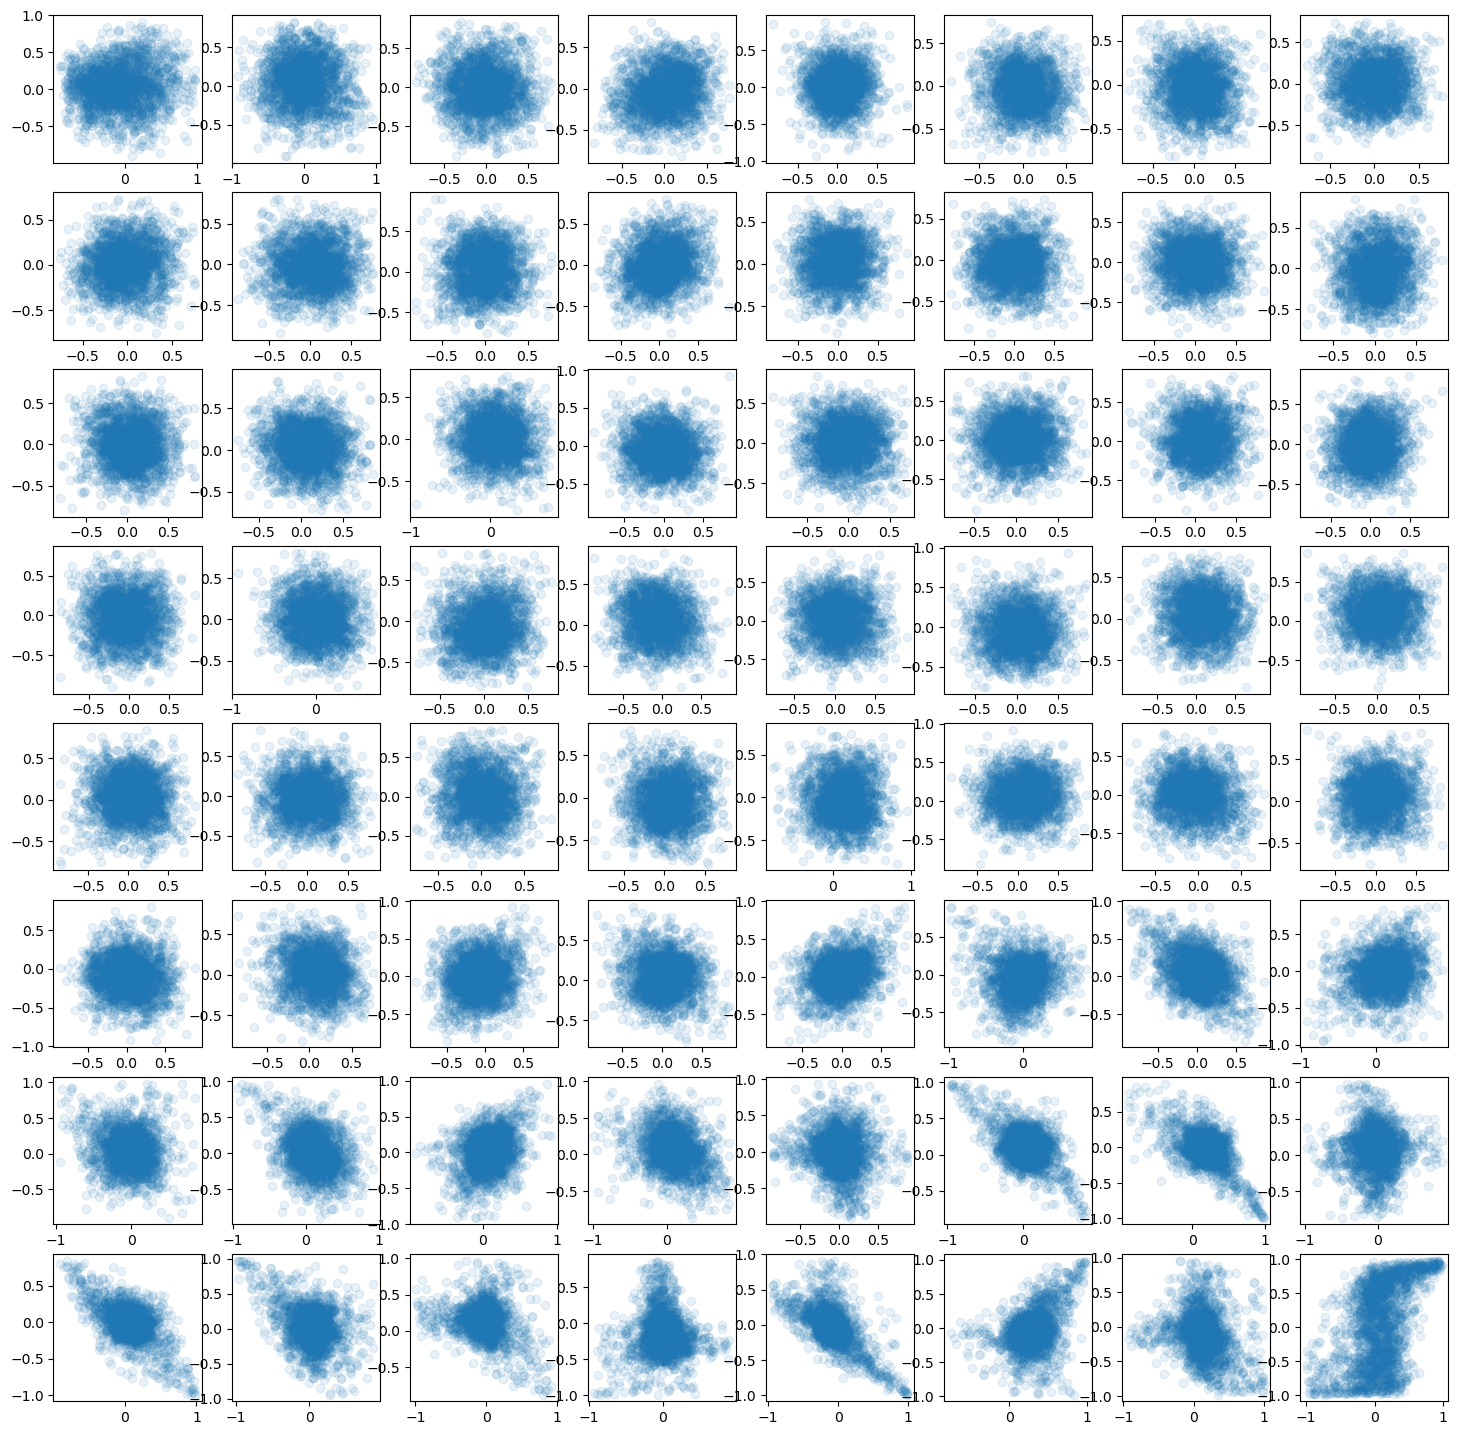

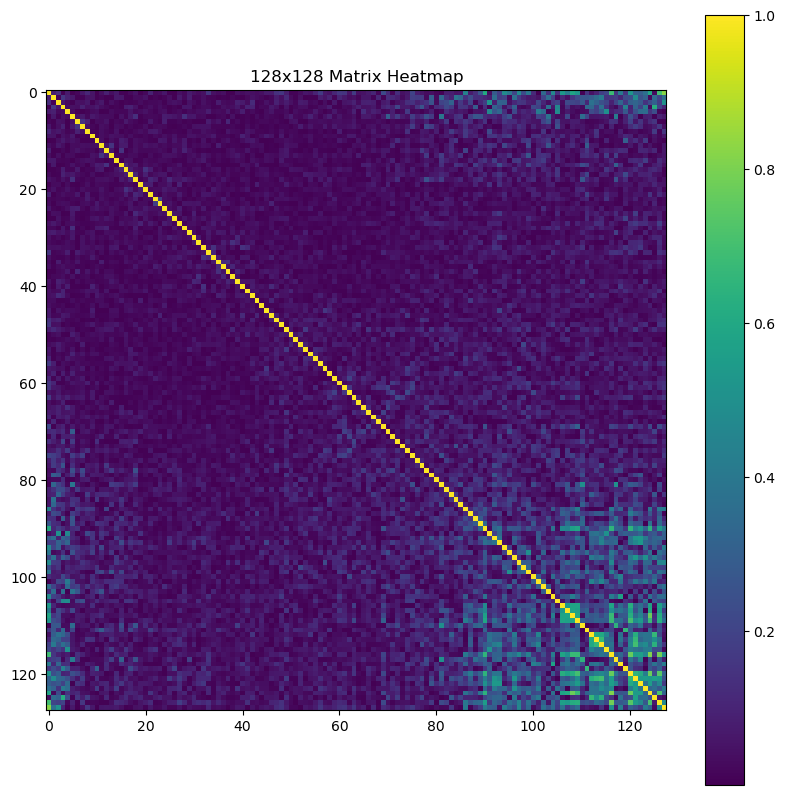

In [20]:
import matplotlib.pyplot as plt
display.clear_output()

model = model_list[0]
model.eval()
with torch.no_grad():
    test_data = model(test_data, M=hp.M)

plot(test_data['x'])
plot(test_data['y'])

with torch.no_grad():
    z = model.prior.sample(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)

z = test_data['z_copy'].data.cpu().numpy()
plt.figure(figsize=[18, 18])
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.scatter(z[:, i*2], z[:, i*2+1], alpha=0.1)
plt.show()    

corrcoef = torch.corrcoef(test_data['z_copy'].T).abs().data.cpu().numpy()
# Plotting the matrix as a heatmap
plt.figure(figsize=(10, 10))
plt.imshow(corrcoef, cmap='viridis')
plt.colorbar()
plt.title('128x128 Matrix Heatmap')
plt.show()

corrcoef = np.mean(corrcoef * (1-np.eye(len(corrcoef))))
writer.add_scalar('corrcoef', corrcoef, step)

from util.mmd_penalty import mmd_penalty
opts = {'pz_scale': 1,
        'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
        'pz': 'normal', # 'normal', 'sphere', 'uniform' 
        'zdim': hp.z_dim
       } 
e = (torch.rand_like(test_data['z_copy'])*2-1)
mmd = mmd_penalty(test_data['z_copy'], e, opts).item()
writer.add_scalar('MMD', mmd, step)